In [1]:
import json
import random
import os

import cv2
import cyvlfeat
from matplotlib import pyplot as plt
import numpy as np
from pprint import pprint
import torch
import torchvision

from ipywidgets import *
from IPython.display import display

device = "cpu"

%matplotlib inline

# Function Definitions

In [12]:
def avg_blur_config(ksize):
    return {"ksize": (ksize, ksize)}

def median_blur_config(ksize):
    return {"ksize": (ksize, ksize)}

def bilateral_filter_config(d, sigmaColor, sigmaSpace):
    return {"d": d, "sigmaColor": sigmaColor, "sigmaSpace": sigmaSpace}

def gaussian_blur_config(ksize, sigmaX):
    return {"ksize": (ksize, ksize), "sigmaX": sigmaX}

def threshold_config(thresh, maxval, type):
    return {"thresh": thresh, "maxval": maxval, "type": type}

def canny_config(threshold1, threshold2):
    return {"threshold1": threshold1, "threshold2": threshold2}

# ----------------------------------------------- #

def convert_grayscale(image, **kwargs): # **kwargs is ignored
    print("Converting to grayscale")
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def enhance_contrast(image, **kwargs): # **kwargs is ignored
    print("Enhancing contrast")
    return cv2.equalizeHist(image)

def apply_threshold(image, **kwargs):
    print(kwargs)
    gray_img = convert_grayscale(image)
    _retval, thresh_image = cv2.threshold(gray_img, **kwargs)
    return thresh_image

def apply_filter(image, kernel):
    return cv2.filter2D(image, ddepth=-1, kernel=kernel)

def apply_avg_blur(image, **kwargs):
    print("Applying average blur with args:", kwargs)
    return cv2.blur(image, **kwargs)

def apply_median_blur(image, **kwargs):
    print("Applying median blur with args:", kwargs)
    return cv2.medianBlur(img, ksize=(ksize,ksize))

def apply_bilateral_filter(image, **kwargs):
    print("Applying bilateral filter with args:", kwargs)
    return cv2.bilateralFilter(image, **kwargs)

def apply_gaussian_blur(image, **kwargs):
    print("Applying Gaussian blur with args:", kwargs)
    return cv2.GaussianBlur(image, **kwargs)

def apply_laplacian(image, **kwargs): # TODO:
    print("Applying Laplacian filter for vertical and horizontal edges with args:", kwargs)
    return cv2.Laplacian(image, cv2.CV_64F)

def apply_sobelx(image, **kwargs): # TODO:
    print("Applying Sobel filter for vertical edges (along y-axis) with args:", kwargs)
    return cv2.Sobel(image, cv2.CV_64F, dx=1, dy=0, ksize=5)

def apply_sobely(image, **kwargs): # TODO:
    print("Applying Sobel filter for horizontal edges (along x-axis) with args:", kwargs)
    return cv2.Sobel(image, cv2.CV_64F, dx=0, dy=1, ksize=5)

def apply_canny(image, **kwargs):
    print("Applying canny with args:", kwargs)
    return cv2.Canny(image, **kwargs)

def apply_contour(image, **kwargs): # TODO: thresh and maxval should be configurable, different thresholding types can be tried.
    gray_img = convert_grayscale(image)
    _retval, thresh_img = cv2.threshold(gray_img, thresh=225, maxval=255, type=cv2.THRESH_BINARY)
    _image, contours, _hierarchy = cv2.findContours(thresh_img, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
    return contours # contours is a Python list of all the contours in the image. Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.

def apply_hough_line(image, **kwargs): # TODO:
    gray_img = convert_grayscale(image)
    _, thresh_img = cv2.threshold(gray_img, thresh=225, maxval=255, type=cv2.THRESH_BINARY)
    line_params = cv2.HoughLines(thresh_img, rho=1, theta=np.pi/180, threshold=200)
    print(line_params[0].shape)
    end_pts = []
    for rho, theta in line_params[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        end_pts.append([(x1,y1), (x2,y2)])
    
    return end_pts

# ----------------------------------------------- #

def save_config(filename, config, selected):
    if not filename.endswith(".json"):
        filename += ".json"
        
    filtered_config = {k: config[k] for k in selected}
    
    with open(filename, "w") as file:
        json.dump(filtered_config, file, indent=4)
        
    print(filename, "is created.")
    
def load_config(json_content, config, config_ui):
    print("Previous State:")
    pprint(config)
    
    config.update(json.loads(json_content))
    update_ui_with_state(config, config_ui)
    print("Update Configuration and UI state:")
    pprint(config)
    
def update_state_with_ui(config, config_ui, selected):
    for k in selected:
        if config_ui[k]:
            config[k] = config_ui[k].result

def update_ui_with_state(config, config_ui):
    # For each function, get UI element bound to it
    for k, v in config_ui.items():
        # If there is a UI element bound
        if v is not None:
            # Get sub UI elements
            for c in v.children[:-1]:
                p = c.description    # Fetch parameter name
                value = config[k][p] # Fetch respective function configuration and update UI
                if p == "ksize" and isinstance(value, (tuple,list)): # Due to the possible mismatch between internal config state and cv2 parameter convention
                    value = value[0]
                c.value = value
    
def show_image(image, h=10, w=10, cmap='viridis'):
    plt.figure(figsize=(w,h))
    plt.imshow(image, cmap=cmap)
    plt.show()
    
def show_contours(image, contours, contourIdx='all', cmap=None):
    # To draw all the contours in the image, set contourIdx to -1
    if contourIdx == 'all':
        contourIdx = -1

    image = cv2.drawContours(image, contours, contourIdx=contourIdx, color=(255,0,0), thickness=3)
    show_image(image, cmap=cmap)
    
def show_lines(image, end_pts, cmap=None):
    for ep in end_pts:
        image = cv2.line(image, ep[0], ep[1], color=(255,0,0), thickness=2)
    
    show_image(image, cmap=cmap)

def show_image_pairs(left, right, h=15, w=15):
    f, ax = plt.subplots(1,2)
    f.set_figheight(h)
    f.set_figwidth(w)
    ax[0].imshow(left)
    ax[1].imshow(right)
    plt.show()

# Load Frames

In [13]:
# indices = list(range(1, 16))
# choice = str(random.choice(indices))
# print("Choice:", choice)
choice = str(13)

rgb_img_ext = choice + "_rgb.png"
depth_img_ext = choice + "_depth.png"
depth_arr_ext = choice + "_depth.npy"

folders = os.listdir("frames")
folders = list(map(lambda folder: os.path.join("frames", folder), folders))
triplets = []
for folder in folders:
    rgb_im_path = os.path.join(folder, rgb_img_ext)
    depth_im_path = os.path.join(folder, depth_img_ext)
    depth_arr_path = os.path.join(folder, depth_arr_ext)
    
    rgb_img = cv2.imread(rgb_im_path, cv2.IMREAD_COLOR)     # BGR image
    depth_img = cv2.imread(depth_im_path, cv2.IMREAD_COLOR) # BGR image
    depth_arr = None # np.load(depth_arr_path, allow_pickle=True) # TODO: Save frames with allow_pickle=False
    triplets.append((rgb_img, depth_img, depth_arr))
    
print("Number of triplets:", len(triplets))

Number of triplets: 8


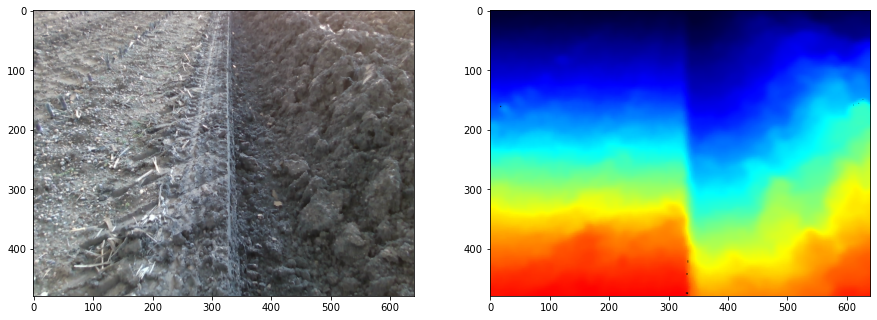

In [14]:
# indices = list(range(8))
# choice = str(random.choice(indices))
# print("Choice:", choice)
choice = 4

rgb_img, depth_img, depth_arr = triplets[choice]

show_image_pairs(rgb_img, depth_img)

# Configuration Parameters

In [15]:
# Parameters to tune
config = {
    "Grayscale": {},
    "Contrast": {},
    "Threshold": {
        "thresh": 127, 
        "maxval": 255, 
        "type": cv2.THRESH_BINARY,
    },
    "Average Blur": {
        "ksize": 3
    },
    "Median Blur": {
        "ksize": 3
    },
    "Bilateral Filter": {
        "d":9, 
        "sigmaColor": 75, 
        "sigmaSpace": 75
    },
    "Gaussian Blur": {
        "ksize": 5, 
        "sigma": 3
    },
    "Canny Edges": {
        "threshold1": 25,
        "threshold2": 50
    },
    
}

# Binding names to actual methods:
preproc_funcs = {
    "Grayscale": convert_grayscale,
    "Contrast": enhance_contrast,
    "Threshold": apply_threshold,
    "Average Blur": apply_avg_blur,
    "Median Blur": apply_median_blur,
    "Bilateral Filter": apply_bilateral_filter,
    "Gaussian Blur": apply_gaussian_blur,   
}

detect_funcs = {
    "Canny Edges": apply_canny,
}

# Defining UI elements for configurations
threshold_ui = interactive(threshold_config, thresh=(0,255), maxval=(0,255), type={"Binary": cv2.THRESH_BINARY, "Mask": cv2.THRESH_MASK})
avg_blur_ui = interactive(avg_blur_config, ksize=(1,20))
median_blur_ui = interactive(median_blur_config, ksize=(1,20))
bilateral_filter_ui = interactive(bilateral_filter_config, d=(1,20), sigmaColor=(1,100), sigmaSpace=(1,100))
gaussian_blur_ui = interactive(gaussian_blur_config, ksize=(1,20), sigmaX=(1,20))
canny_ui = interactive(canny_config, threshold1=(0,100), threshold2=(0,100))

# Binding names to the configuration UI elements
preproc_ui = {
    "Grayscale": None,
    "Contrast": None,
    "Threshold": threshold_ui,
    "Average Blur": avg_blur_ui,
    "Median Blur": median_blur_ui,
    "Bilateral Filter": bilateral_filter_ui,
    "Gaussian Blur": gaussian_blur_ui,   
}

detect_ui = {
    "Canny Edges": canny_ui,
}

# Preprocessing

In [16]:
style = {
    'description_width': 'initial'
}

preproccessing = SelectMultiple(
    options=preproc_ui.keys(),
    value=[],
    rows=len(preproc_ui.keys()),
    description='Preprocessing',
    disabled=False,
    style=style
)

detectors = SelectMultiple(
        options=detect_ui.keys(),
        value=[],
        rows=len(detect_ui.keys()),
        description='Detectors',
        disabled=False,
        style=style
)

selection = HBox([preproccessing, detectors])

display(selection)

In [17]:
selected = preproccessing.value + detectors.value
config_ui = {**preproc_ui, **detect_ui}
for k in selected:
    if config_ui[k]:
        print(k + ":")
        display(config_ui[k])

Threshold:


interactive(children=(IntSlider(value=127, description='thresh', max=255), IntSlider(value=127, description='m…

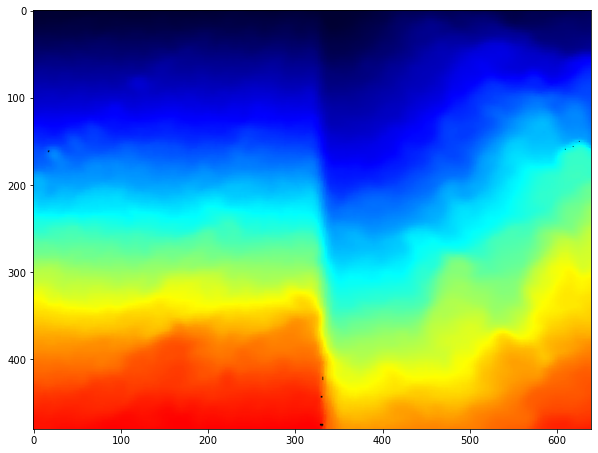

{'thresh': 221, 'maxval': 225, 'type': 0}
Converting to grayscale
(480, 640)


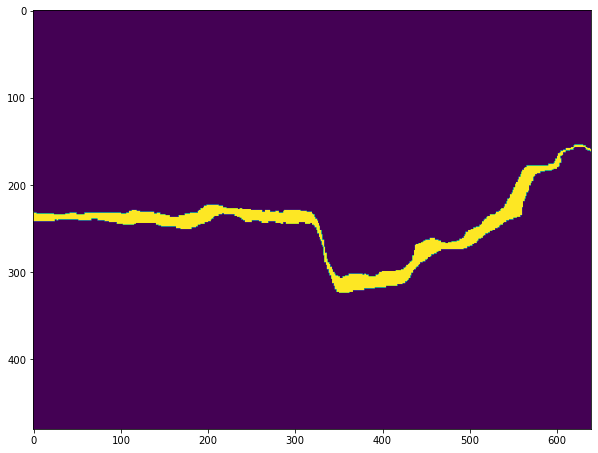

In [25]:
# Update parameters based on UI elements
update_state_with_ui(config, config_ui, selected)

orig = depth_img
modified = orig.copy() # Modify the deep copy of the original image
show_image(orig)

for p in preproccessing.value:
    modified = preproc_funcs[p](modified, **config[p])
    print(modified.shape)
    show_image(modified)

# Feature Extraction

Applying canny with args: {'threshold1': 25, 'threshold2': 50}


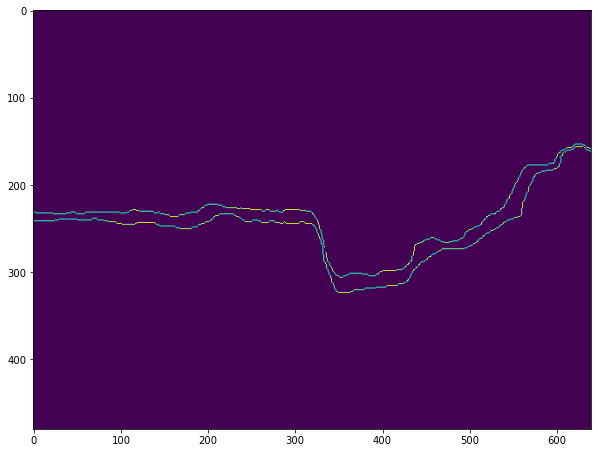

In [26]:
for d in detectors.value:
    modified = detect_funcs[d](modified, **config[d])
    show_image(modified)

# Store Current Settings

In [ ]:
text = Text(
    value='config.json',
    placeholder='Enter a filename',
    description='Filename:',
    disabled=False
)


button = Button(
    description='Store',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
)

mini_form = HBox([text, button])

button.on_click(lambda _: save_config(text.value, config, selected))

display(mini_form)

# Load Settings

In [ ]:
uploader_ui = FileUpload(
    accept='.json',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)

uploader_ui.observe(lambda _: load_config(*uploader_ui.data, config, config_ui), names='_counter')

display(uploader_ui)

# Experimental

In [ ]:
orig = depth_img
modified = orig.copy()
contours = apply_contour(modified)
show_image(orig)
show_contours(modified, contours, contourIdx=-1)

In [ ]:
orig = depth_img
end_pts = apply_hough_line(orig)
show_lines(orig, end_pts)

In [ ]:
orig = depth_img
gray = convert_grayscale(orig)
edges1 = apply_laplacian(orig)
edges2 = apply_sobelx(orig)
edges3 = apply_sobely(orig)
show_image(gray, cmap="gray")
show_image(edges1, cmap="gray")
show_image(edges2, cmap="gray")
show_image(edges3, cmap="gray")

 # Help

## cv2.COLOR_XXX

[cv2.COLOR_XXX](https://vovkos.github.io/doxyrest-showcase/opencv/sphinx_rtd_theme/enum_cv_ColorConversionCodes.html)

## cv2.THRESH_XXX

[Thresholding](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html)

[cv2.THRESH_XXX](https://vovkos.github.io/doxyrest-showcase/opencv/sphinx_rtd_theme/enum_cv_ThresholdTypes.html)

## cv2.cvtColor

In [ ]:
help(cv2.cvtColor)

## cv2.equalizeHist

In [ ]:
help(cv2.equalizeHist)

## cv2.threshold

In [11]:
help(cv2.threshold)

Help on built-in function threshold:

threshold(...)
    threshold(src, thresh, maxval, type[, dst]) -> retval, dst
    .   @brief Applies a fixed-level threshold to each array element.
    .   
    .   The function applies fixed-level thresholding to a multiple-channel array. The function is typically
    .   used to get a bi-level (binary) image out of a grayscale image ( #compare could be also used for
    .   this purpose) or for removing a noise, that is, filtering out pixels with too small or too large
    .   values. There are several types of thresholding supported by the function. They are determined by
    .   type parameter.
    .   
    .   Also, the special values #THRESH_OTSU or #THRESH_TRIANGLE may be combined with one of the
    .   above values. In these cases, the function determines the optimal threshold value using the Otsu's
    .   or Triangle algorithm and uses it instead of the specified thresh.
    .   
    .   @note Currently, the Otsu's and Triangle methods a

## cv2.filter2D

In [ ]:
help(cv2.filter2D)

## cv2.blur

In [ ]:
help(cv2.blur)

## cv2.medianBlur

In [ ]:
help(cv2.medianBlur)

## cv2.bilateralFilter

In [ ]:
help(cv2.bilateralFilter)

## cv2.GaussianBlur

In [ ]:
help(cv2.GaussianBlur)

## cv2.Sobel

In [ ]:
help(cv2.Sobel)

## cv2.Laplacian

In [ ]:
help(cv2.Laplacian)

## cv2.Canny

In [ ]:
help(cv2.Canny)

## cv2.findContours

[Convex Hull](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html#convex-hull)

[Fitting a Line](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html#fitting-a-line)

[Mask and Pixel Points](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_properties/py_contour_properties.html#mask-and-pixel-points)

[Match Shapes](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contours_more_functions/py_contours_more_functions.html#match-shapes)

In [ ]:
help(cv2.findContours)

## cv2.HoughLines

[Hough Transform Theory](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html#theory)

In [ ]:
help(cv2.HoughLines)